# ONNX visualization

[ONNX](https://onnx.ai/) is a serialization format for machine learned model. It is a list of mathematical functions used to describe every prediction function for standard and deep machine learning. Module [onnx](https://github.com/onnx/onnx) offers some tools to [display ONNX graph](http://www.xavierdupre.fr/app/sklearn-onnx/helpsphinx/auto_examples/plot_pipeline.html). [Netron](https://github.com/lutzroeder/netron) is another approach. The following notebooks explore a ligher visualization.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Train a model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

## Convert a model

In [3]:
import numpy
from mlprodict.onnx_conv import to_onnx
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

## Explore it with OnnxInference

In [4]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(model_onnx)
sess

OnnxInference(...)

In [5]:
print(sess)

OnnxInference(...)
    ir_version: 4
    producer_name: "skl2onnx"
    producer_version: "1.7.1076"
    domain: "ai.onnx"
    model_version: 0
    doc_string: ""
    graph {
      node {
        input: "X"
        output: "label"
        output: "probability_tensor"
        name: "LinearClassifier"
        op_type: "LinearClassifier"
        attribute {
          name: "classlabels_ints"
          ints: 0
          ints: 1
          ints: 2
          type: INTS
        }
        attribute {
          name: "coefficients"
          floats: 0.3895888328552246
          floats: 1.3643852472305298
          floats: -2.140394449234009
          floats: -0.9475928544998169
          floats: 0.3562876284122467
          floats: -1.4181873798370361
          floats: 0.5958272218704224
          floats: -1.3317818641662598
          floats: -1.5090725421905518
          floats: -1.3937636613845825
          floats: 2.168299436569214
          floats: 2.3770956993103027
          type: FLOATS
  

## dot

In [6]:
dot = sess.to_dot()
print(dot)

digraph{
  ranksep=0.25;
  nodesep=0.05;
  orientation=portrait;

  X [shape=box color=red label="X\nfloat((0, 4))" fontsize=10];

  output_label [shape=box color=green label="output_label\nint64((0,))" fontsize=10];
  output_probability [shape=box color=green label="output_probability\n[{int64, {'kind': 'tensor', 'elem': 'float', 'shape': }}]" fontsize=10];


  label [shape=box label="label" fontsize=10];
  probability_tensor [shape=box label="probability_tensor" fontsize=10];
  LinearClassifier [shape=box style="filled,rounded" color=orange label="LinearClassifier\n(LinearClassifier)\nclasslabels_ints=[0 1 2]\ncoefficients=[ 0.38958883  1.36...\nintercepts=[ 0.23760676  0.8039...\nmulti_class=1\npost_transform=b'LOGISTIC'" fontsize=10];
  X -> LinearClassifier;
  LinearClassifier -> label;
  LinearClassifier -> probability_tensor;

  probabilities [shape=box label="probabilities" fontsize=10];
  Normalizer [shape=box style="filled,rounded" color=orange label="Normalizer\n(Normalizer)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)  # add local=True if nothing shows up

## magic commands

The module implements a magic command to easily display graphs.

In [8]:
%load_ext mlprodict

The mlprodict extension is already loaded. To reload it, use:
  %reload_ext mlprodict


In [9]:
# add -l 1 if nothing shows up
%onnxview model_onnx

## Shape information

It is possible to use the python runtime to get an estimation of each node shape.

In [10]:
%onnxview model_onnx -a 1

The shape ``(n, 2)`` means a matrix with an indefinite number of rows and 2 columns.

## runtime

Let's compute the prediction using a Python runtime.

In [11]:
prob = sess.run({'X': X_test})['output_probability']
prob[:5]

{0: array([0.84339281, 0.01372288, 0.77424892, 0.00095374, 0.04052374]),
 1: array([0.15649399, 0.71819778, 0.22563196, 0.25979154, 0.7736001 ]),
 2: array([1.13198419e-04, 2.68079336e-01, 1.19117272e-04, 7.39254721e-01,
        1.85876160e-01])}

In [12]:
import pandas
prob = pandas.DataFrame(list(prob)).values
prob[:5]

array([[8.43392810e-01, 1.56493992e-01, 1.13198419e-04],
       [1.37228844e-02, 7.18197780e-01, 2.68079336e-01],
       [7.74248918e-01, 2.25631964e-01, 1.19117272e-04],
       [9.53737402e-04, 2.59791542e-01, 7.39254721e-01],
       [4.05237433e-02, 7.73600097e-01, 1.85876160e-01]])

Which we compare to the original model.

In [13]:
clr.predict_proba(X_test)[:5]

array([[8.43392800e-01, 1.56494002e-01, 1.13198441e-04],
       [1.37228764e-02, 7.18197725e-01, 2.68079398e-01],
       [7.74248907e-01, 2.25631976e-01, 1.19117296e-04],
       [9.53736800e-04, 2.59791543e-01, 7.39254720e-01],
       [4.05237263e-02, 7.73600070e-01, 1.85876204e-01]])

Some time measurement...

In [14]:
%timeit clr.predict_proba(X_test)

86.7 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit sess.run({'X': X_test})['output_probability']

52.5 µs ± 4.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


With one observation:

In [16]:
%timeit clr.predict_proba(X_test[:1])

77.6 µs ± 4.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit sess.run({'X': X_test[:1]})['output_probability']

40.6 µs ± 913 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%matplotlib inline

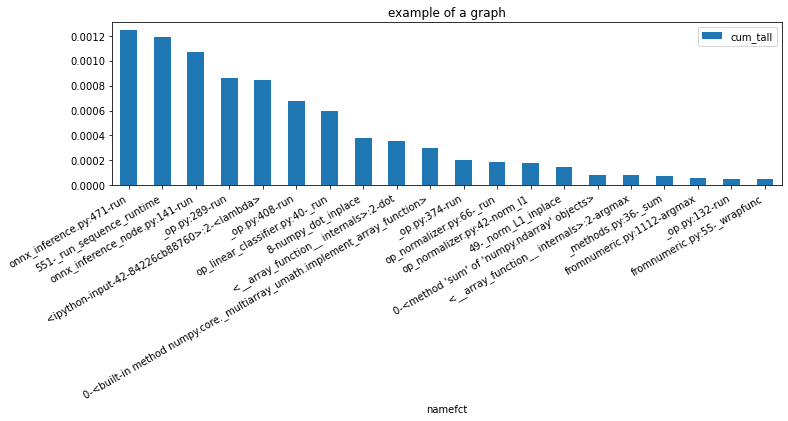

In [19]:
from pyquickhelper.pycode.profiling import profile
pr, df = profile(lambda: sess.run({'X': X_test})['output_probability'], as_df=True)
ax = df[['namefct', 'cum_tall']].head(n=20).set_index('namefct').plot(kind='bar', figsize=(12, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');

## Add metadata

It is possible to add metadata once the model is converted.

In [20]:
meta = model_onnx.metadata_props.add()
meta.key = "key_meta"
meta.value = "value_meta"

In [21]:
list(model_onnx.metadata_props)

[key: "key_meta"
 value: "value_meta"]

In [22]:
model_onnx.metadata_props[0]

key: "key_meta"
value: "value_meta"

## Simple PCA

In [23]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(X)

PCA(n_components=2)

In [24]:
pca_onnx = to_onnx(model, X.astype(numpy.float32))

In [25]:
%load_ext mlprodict

The mlprodict extension is already loaded. To reload it, use:
  %reload_ext mlprodict


In [26]:
%onnxview pca_onnx -a 1

The graph would probably be faster if the multiplication was done before the subtraction because it is easier to do this one inline than the multiplication.